# Linear least squares fit

## Tasks

Perform a least squares fit of a parabola

$$ y(x) = \theta_0 + \theta_1 x + \theta_2 x^2$$

for the seven independent measurments $(x_i, y_i)$ given by $(-0.75, 1.0 \pm 1.0)$, $(-0.5, 4.0 \pm 1.0)$, $(-0.25, 4.0 \pm 0.5)$, $(0.0, 5.5 \pm 0.5)$, $(0.25, 4.5 \pm 0.5)$, $(0.5, 5.5 \pm 1.0)$, $(0.75, 3.0 \pm 1.0)$. 

### Hints

1) The following numpy functions might come in very handy
* diagonal matrix from vector v in numpy: *A = np.diagflat(v)*
* matrix from column vectors v0, v1, v2: *A = np.column_stack((v0, v1, v2))*
* multiplication of matrices A and B in numpy: *C = A.dot(B)*
* transposed matrix: *A_T = np.transpose(A)*
* inverse matrix: *A_inv = inv(A)*, this requires *from numpy.linalg import inv*

2) It might be useful to write a function which returns the uncertainty $\sigma_y$ for a numpy array of $x$ values. A function $f$ that only works for a scalar value $x$ can be vectorized (i.e., it works also for numpy arrays) with *numpy.vectorize*.

3) Data points with error bars can be drawn with *plt.errorbar(x, y, yerr=sigma_y)*

4) A band between $y$ values can be drawn with the aid of *matplotlib.pyplot.fill_between*

## Comments on Python's `iminuit`

The KIP service has iminuit version 1.3.8. Please note that the most recent version is $\geq2.0.0$ and that the [documentation](https://iminuit.readthedocs.io/en/stable/) applies to *that* version. Some backward-incompatible changes have been introduced, some of which changed some interfaces. For your tasks that mainly affects the `minuit.Minuit` constructor. The following shows the construction of a `Minuit` object for version 1.3.8 (in case you use the KIP service or a version $<2.0.0$) and $\geq2.0.0$ (in case you use another service implementing a higher version), respectively.
```python
from iminuit import Minuit

def func(par1, par2, ..., parN):
    return minimise_something(par1, par2, ..., parN)

# least squares method: errordef=1
# likelihood method: errordef=0.5
m = Minuit(func, par1=0.1, par2=0.1, ..., parN=0.1, errordef=1)
```

And this would be the equivalent workflow for versions >2.0.0
```python
from iminuit import Minuit

def func(par1, par2, ..., parN):
    return minimise_something(par1, par2, ..., parN)

# least squares method: errordef=Minuit.LEAST_SQUARES
# likelihood method: errordef=Minuit.LIKELIHOOD

# add errordef as an attribute of your defined minimisation function which will be checked for when optimised
func.errordef = Minuit.LEAST_SQUARES
m = Minuit(func, par1=0.1 par2=0.1, ..., parN=0.1)
```

Another (potenitally) Jupiter related *feature* is the fact that `m.migrad()`, `m.matrix()`, `m.minos()` etc. can yield a nice summary of the respective procedure. However, in order to show it, either of these methods (and potentially others in case you use them) have to be *the last line of a code cell*. If there is *anything* coming afterwards, the output will not be printed, hence, for anything that follows, it is recommended to start a new code cell.


## Solution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
#from iminuit import Minuit

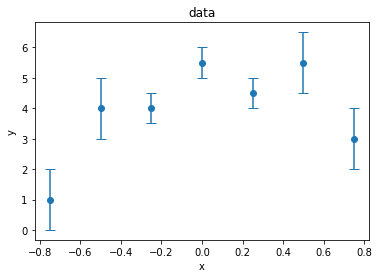

In [2]:
# data
x = np.array([-0.75, -0.5, -0.25, 0., 0.25, 0.5, 0.75])
y = np.array([1., 4.0, 4., 5.5, 4.5, 5.5, 3])
sigma_y = np.array([1, 1, 0.5, 0.5, 0.5, 1, 1])

plt.errorbar(x,y,sigma_y, fmt='o', capsize=5)
plt.title('data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### a) Determine the best fit parameters $\hat \theta_i$ and their covariances using the formula for linear least squares fits.



In [3]:
C = np.diagflat(sigma_y**2)
A = np.column_stack((x**0, x, x**2))

AT = A.T
Cinv = inv(C)

G = inv(AT.dot(Cinv.dot(A))).dot(AT.dot(Cinv))

parameters = G.dot(y)
print('fitted parameters:')
print(f'theta_0: \t {parameters[0]}\ntheta_1: \t {parameters[1]}\ntheta_2: \t {parameters[2]}\n')

parameters_cov = inv(AT.dot(Cinv.dot(A)))
print('covariance matrix:')
print(parameters_cov)

fitted parameters:
theta_0: 	 4.99373795761079
theta_1: 	 1.2941176470588234
theta_2: 	 -4.89402697495183

covariance matrix:
[[ 0.0973025   0.         -0.26204239]
 [ 0.          0.47058824  0.        ]
 [-0.26204239  0.          1.97302505]]


### b) Determine the $\chi_\mathrm{obs}^2$ for the best fit parameter. What is the number of degrees of freedom? Plot the $\chi^2$ distribution and indicate $\chi_\mathrm{obs}^2$ in this plot (e.g. by drawing a line at this value). What is the $p$-value for this fit?

In [4]:
mu = A.dot(parameters)
chi_obs = np.sum((y - mu)**2 / sigma_y**2)
chi_obs

4.661070497563187

In [5]:
#Anzahl der Freiheitsgrade
nF = len(x) - 3
nF

4

In [6]:
from scipy.special import gamma
def chi(z, n):
    return (z**(n/2-1)*np.exp(-z/2)) / (2**(n/2)*gamma(n/2))

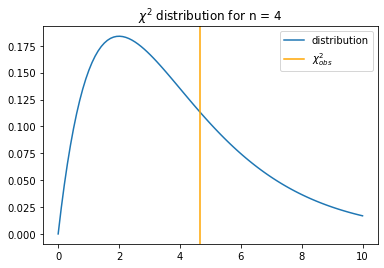

In [7]:
z_line = np.linspace(0,10,100)
plt.title(f'$\chi^2$ distribution for n = {nF}')
plt.plot(z_line, chi(z_line,nF), label='distribution')
plt.axvline(chi_obs, color='orange', label='$\chi_{obs}^2$')
plt.legend()
plt.show()

In [8]:
from scipy.integrate import quad
F, F_err = quad(chi, 0, chi_obs, args=(nF))
p = 1 - F
p

0.3238735159316912

The p-value is with 0.32 ok (larger than 0.05).

### c) Plot the fitted parabola and the $1\sigma$ error band around it as obtaind from the error propagation formula $\sigma_y^2 = A^\mathrm{T} U A$. What is the predicted value $y$ at $x=1$ and its uncertainty?

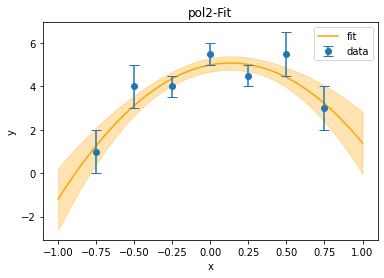

In [9]:
def pol2(x, a,b,c):
    return a+b*x+c*x*x

x_line = np.linspace(-1,1,100)
A_line = np.column_stack((x_line**0, x_line, x_line**2))
y_line = A_line.dot(parameters)

def get_sigma(parameters_cov, x):
    A = np.array([1, x, x**2], dtype=object)
    return np.sqrt(A.T.dot(parameters_cov.dot(A)))

sigma_y_line = get_sigma(parameters_cov, x_line)

plt.xlabel('x')
plt.ylabel('y')
plt.title('pol2-Fit')
plt.errorbar(x,y,sigma_y, fmt='o', capsize=5, zorder=2, label='data')
plt.plot(x_line, y_line, color='orange',zorder=1, label='fit')
plt.fill_between(x_line, y_line-sigma_y_line, y_line+sigma_y_line, alpha=0.3, color='orange',zorder=0)
plt.legend()
plt.show()

In [10]:
y1 = pol2(1, *parameters)
y1_err = get_sigma(parameters_cov, 1)
print(f'y = {y1} +- {y1_err}')

y = 1.3938286297177838 +- 1.4201517559263135


As one can see in the plot above the values on the left and right cannot be determined exact with this fit.

### d) Compare the fit result and the covariance matrix with the results obtained with iminuit. Do the results agree?

In [11]:
from iminuit import Minuit

def LSQ(a, b, c):
    return np.sum((y - pol2(x, a, b, c)) ** 2 / sigma_y ** 2)

LSQ.errordef = Minuit.LEAST_SQUARES
m = Minuit(LSQ, a=0, b=0, c=0)

print('own results:')
print(parameters)
print(parameters_cov)
print('\nminuit results:')
m.migrad()

own results:
[ 4.99373796  1.29411765 -4.89402697]
[[ 0.0973025   0.         -0.26204239]
 [ 0.          0.47058824  0.        ]
 [-0.26204239  0.          1.97302505]]

minuit results:


┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 4.661                      │              Nfcn = 59               │
│ EDM = 3.65e-24 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   4.99    │   0.31    │            │            │         │         │       │
│ 1 │ b    │    1.3    │    0.7    │            │            │         │         │       │
│ 2 │ c    │   -4.9    │    1.4    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬────────────────────────────┐
│   │        a        b        c │
├───┼────────────────────────────┤
│ a │   0.0973 3.53e-11   -0.262 │
│ b │ 3.53e-11    0.471 1.59e-10 │
│ c │   -0.262 1.59e-10     1.97 │
└───┴────────────────────────────┘

Apart from numerical differences are the results the same.

### e) Determine the $p$-value for a straight-line fit. Is this an acceptable description of the data?

In [12]:
C = np.diagflat(sigma_y**2)
A = np.column_stack((x**0, x))

AT = A.T
Cinv = inv(C)

G = inv(AT.dot(Cinv.dot(A))).dot(AT.dot(Cinv))

parameters = G.dot(y)
parameters_cov = inv(AT.dot(Cinv.dot(A)))

mu = A.dot(parameters)
chi_obs = np.sum((y - mu)**2 / sigma_y**2)

F, F_err = quad(chi, 0, chi_obs, args=(nF))
p = 1 - F
p

0.002113232078128635

As we take the same threshold as the one of the script ($p=0.05$): The fit is not acceptable. This can be clearly seen in the plot below:

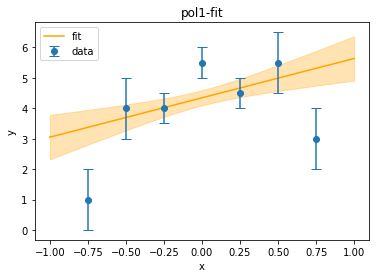

In [13]:
def pol1(x, a,b):
    return a+b*x

x_line = np.linspace(-1,1,100)
A_line = np.column_stack((x_line**0, x_line))
y_line = A_line.dot(parameters)

def get_sigma_line(parameters_cov, x):
    A = np.array([1, x], dtype=object)
    return np.sqrt(A.T.dot(parameters_cov).dot(A))

sigma_y_line = get_sigma_line(parameters_cov, x_line)

plt.title('pol1-fit')
plt.xlabel('x')
plt.ylabel('y')
plt.errorbar(x,y,sigma_y, fmt='o', capsize=5, zorder=2, label='data')
plt.plot(x_line, y_line, color='orange',zorder=1, label='fit')
plt.fill_between(x_line, y_line-sigma_y_line, y_line+sigma_y_line, alpha=0.3, color='orange',zorder=0)
plt.legend()
plt.show()